# Introduction

Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

![title](https://go.apziva.com/static/img/project_10_1.png)


![title](https://go.apziva.com/static/img/project_10_2.jpg)

### Goal(s):

Predict if the page is being flipped using a single image.


Bonus(es):

Predict if a given sequence of images contains an action of flipping.
Submission Instructions:
Project should be implemented with Python
Please name your repository on GitHub with this name without exposing your project information: SXwrsbaVlFLhu5N2

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import os

import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize, rotate, AffineTransform, warp
from tensorflow.keras import models
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, ReLU, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras import optimizers
from tensorflow.keras.applications import *
from keras.callbacks import EarlyStopping



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Data Visualisation


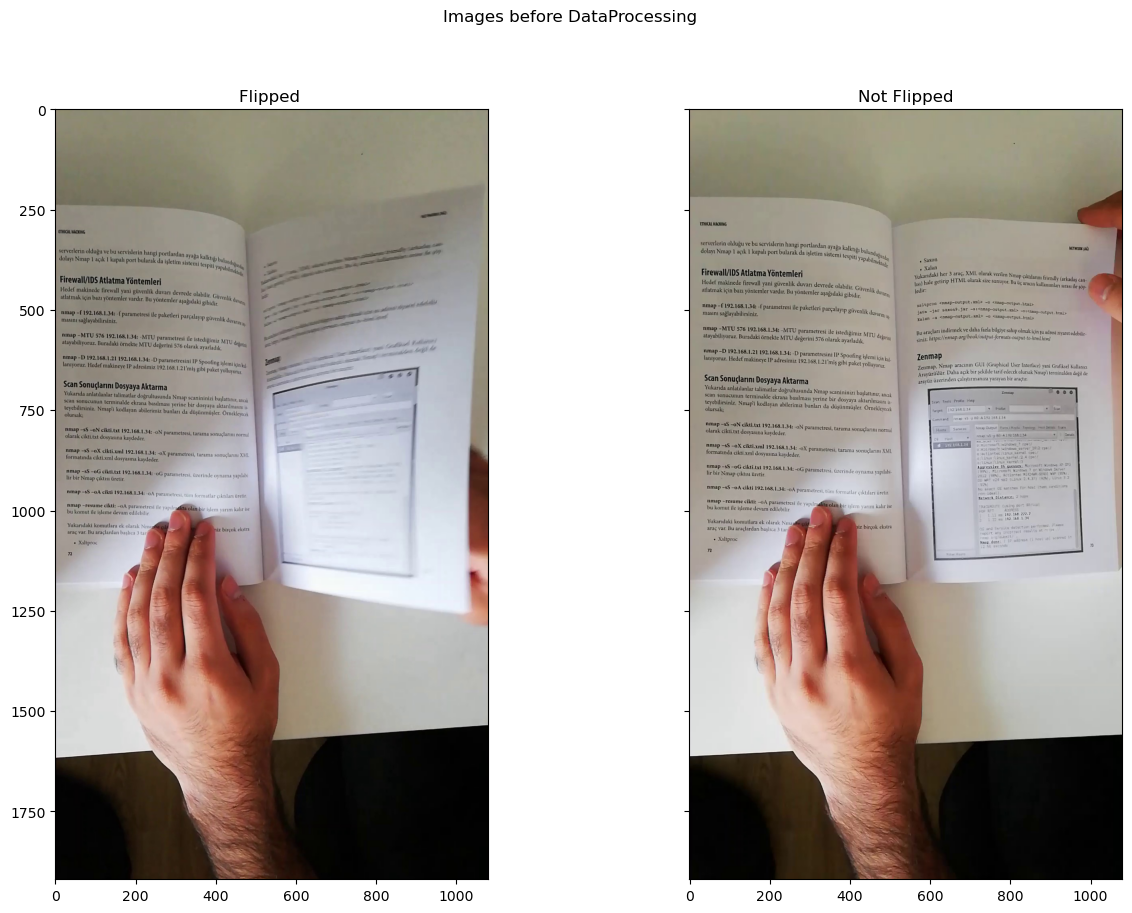

In [2]:
data_flip = plt.imread(r'C:\Users\ibane\OneDrive\Python\Projects\MonReader\images\training\flip\0001_000000010.jpg')
data_notflip = plt.imread(r"C:\Users\ibane\OneDrive\Python\Projects\MonReader\images\training\notflip\0001_000000003.jpg")
fig, ax = plt.subplot_mosaic([['flip', 'notflip']], sharey = True, sharex = True, figsize=(15, 10))
ax['flip'].imshow(data_flip)
im = ax['notflip'].imshow(data_notflip)
ax['flip'].set_title('Flipped ')
ax['notflip'].set_title('Not Flipped')
plt.suptitle('Images before DataProcessing')
plt.show()

In [3]:
print(data_flip.shape)

(1920, 1080, 3)


In [4]:
print(data_notflip.shape)

(1920, 1080, 3)


# Data Description

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

1. Dataset is quite small: let's increase the number of number of datasets by rotating and flipping the images so we have an increased dataset. 
2. As expected, the dataset is labelled so we need to split the testing set into labels and images. This will help us judge the predictions from the model with the actual labels. 

- resize 
- shuffle




### Paths of training and testing datasets

In [5]:
path_training_set = r"C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\training"
path_test_set = r"C:\Users\ibane\OneDrive\Python\Apziva\Apziva - Project 4\images (1)\images\testing"

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(path_training_set,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            seed=27,
                                                            image_size=(320, 180))

validation_dataset = tf.keras.utils.image_dataset_from_directory(path_training_set,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=27,
                                                                 image_size=(320, 180))

test_dataset = tf.keras.utils.image_dataset_from_directory(path_test_set,
                                                           shuffle=True,
                                                           batch_size=597,
                                                           image_size=(320, 180)) 

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [7]:
print(train_dataset.class_names)

['flip', 'notflip']


In [8]:
print(test_dataset.class_names)

['flip', 'notflip']


In [9]:
print(validation_dataset.class_names)

['flip', 'notflip']


In [10]:
train_dataset.cardinality().numpy()

60

In [11]:
validation_dataset.cardinality().numpy()

15

In [12]:
training_images, training_labels = next(iter(train_dataset))

In [13]:
validation_images, validation_labels = next(iter(validation_dataset))

In [14]:
test_images, test_labels = next(iter(test_dataset))

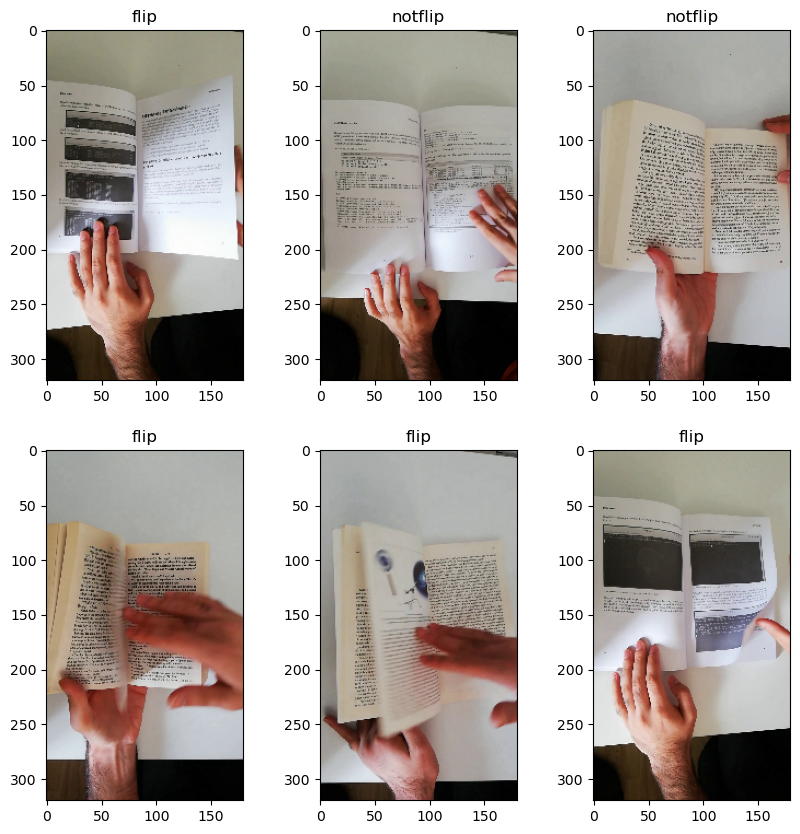

In [15]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

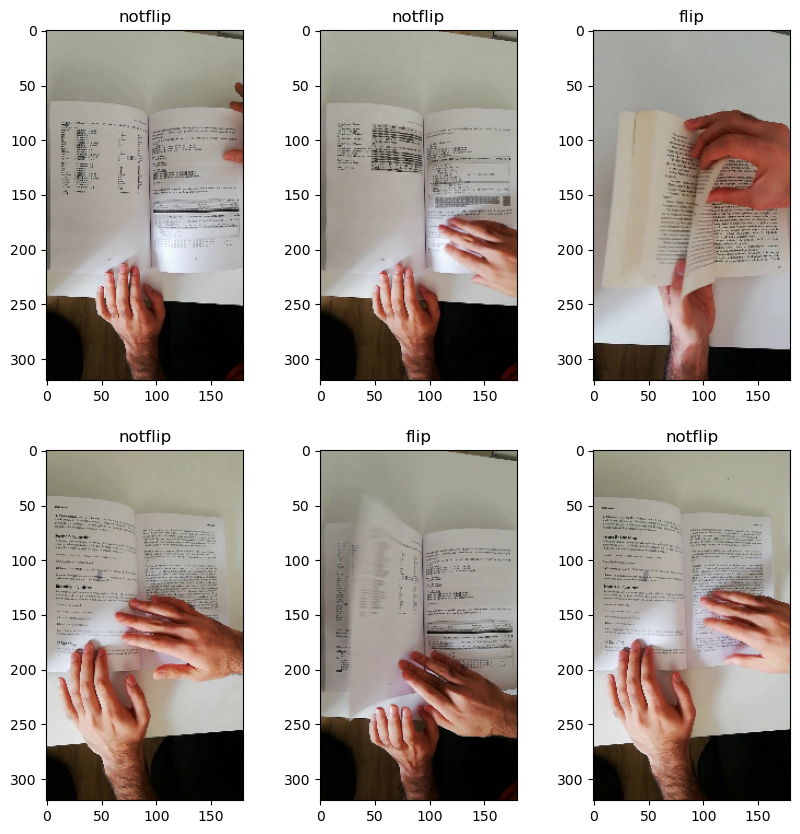

In [16]:
plt.figure(figsize=(10, 10))
class_names = test_dataset.class_names
for images, labels in test_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

# CNN

### Defining the Network

initialiser: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeUniform
Activation functions: https://medium.com/@cmukesh8688/activation-functions-sigmoid-tanh-relu-leaky-relu-softmax-50d3778dcea5
--> Use ReLu and sigmoid for the last 
Optimizer: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/
--> Adam: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [17]:
def CNN(input_size = (320, 180, 3)):
    inputs = Input(input_size)
    
    x = Conv2D(16, (7,7), strides = (2,2), kernel_initializer = he_uniform())(inputs)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = he_uniform())(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), strides = (1, 1), kernel_initializer = he_uniform())(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer = he_uniform())(x)
    x = Dense(32, activation='relu', kernel_initializer = he_uniform())(x)
    outputs = Dense(1, activation='sigmoid', kernel_initializer = he_uniform())(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    return model
    


### Success Metrics
We want the F1 score here

In [18]:
import keras.backend as K

In [19]:

def f1_score(y_true, y_pred): 
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tp_fn = K.sum(K.round(K.clip(y_true, 0, 1)))
    tp_fp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (tp_fp + K.epsilon())
    recall = tp / (tp_fn + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1


In [20]:
#initialize model 
model = CNN((320, 180, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

print(model.summary())
     

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 157, 87, 16)       2368      
                                                                 
 batch_normalization (BatchN  (None, 157, 87, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 157, 87, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 20, 64)        25664 

In [21]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs = 10)

Epoch 1/10
60/60 [==============================] - 73s 1s/step - loss: 1.0114 - accuracy: 0.7325 - f1_score: 0.7018 - val_loss: 8.7475 - val_accuracy: 0.5209 - val_f1_score: 0.6827
Epoch 2/10
60/60 [==============================] - 91s 1s/step - loss: 0.2101 - accuracy: 0.9148 - f1_score: 0.9143 - val_loss: 3.5234 - val_accuracy: 0.5209 - val_f1_score: 0.6798
Epoch 3/10
60/60 [==============================] - 72s 1s/step - loss: 0.0860 - accuracy: 0.9754 - f1_score: 0.9749 - val_loss: 1.6073 - val_accuracy: 0.5858 - val_f1_score: 0.7103
Epoch 4/10
60/60 [==============================] - 70s 1s/step - loss: 0.0506 - accuracy: 0.9828 - f1_score: 0.9818 - val_loss: 1.2294 - val_accuracy: 0.6757 - val_f1_score: 0.7615
Epoch 5/10
60/60 [==============================] - 68s 1s/step - loss: 0.0231 - accuracy: 0.9963 - f1_score: 0.9957 - val_loss: 1.0181 - val_accuracy: 0.6967 - val_f1_score: 0.7689
Epoch 6/10
60/60 [==============================] - 70s 1s/step - loss: 0.0099 - accuracy:

In [22]:
model.evaluate(test_dataset)

1/1 [==============================] - 8s 8s/step - loss: 0.1159 - accuracy: 0.9598 - f1_score: 0.9624


[0.11591474711894989, 0.9597989916801453, 0.962382435798645]

Not a bad outcome! I wanted to try out one of the new models from this article: https://arxiv.org/abs/1905.11946


# EfficientNet

https://keras.io/api/applications/efficientnet/


In [23]:
img_augmentation = models.Sequential([layers.RandomRotation(factor=0.20), layers.RandomFlip()])

In [24]:
enet = EfficientNetB0(weights="imagenet", input_shape=(320, 180, 3), include_top=False)
enet.trainable=False

In [25]:
inputs = tf.keras.Input(shape=(320, 180,3))
x = img_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = enet(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid', name='pred')(x)

enet_train = tf.keras.Model(inputs=inputs, outputs=output)
enet_train.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 320, 180, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 10, 6, 1280)      4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 1280)              0   

In [26]:
enet_train.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', patience= 10, verbose = 1)

In [28]:
res = enet_train.fit(train_dataset, epochs=5, validation_data=validation_dataset, callbacks=[early_stop])

Epoch 1/5
60/60 [==============================] - 298s 5s/step - loss: 0.4504 - accuracy: 0.7978 - val_loss: 0.3853 - val_accuracy: 0.8933
Epoch 2/5
60/60 [==============================] - 236s 4s/step - loss: 0.2926 - accuracy: 0.8762 - val_loss: 0.3587 - val_accuracy: 0.8536
Epoch 3/5
60/60 [==============================] - 243s 4s/step - loss: 0.2617 - accuracy: 0.8913 - val_loss: 0.3443 - val_accuracy: 0.8682
Epoch 4/5
60/60 [==============================] - 265s 4s/step - loss: 0.2385 - accuracy: 0.9018 - val_loss: 0.3264 - val_accuracy: 0.8556
Epoch 5/5
60/60 [==============================] - 293s 5s/step - loss: 0.2503 - accuracy: 0.9028 - val_loss: 0.2822 - val_accuracy: 0.8912


In [29]:
test_images, test_labels = next(iter(test_dataset))
enet_train.evaluate(test_images, test_labels)

19/19 [==============================] - 81s 4s/step - loss: 0.2609 - accuracy: 0.8961


[0.2608834505081177, 0.8961474299430847]

In [30]:
predictions = enet_train.predict(test_images)

19/19 [==============================] - 55s 3s/step


# Success Metrics:

Evaluate model performance based on F1 score, the higher the better.


In [31]:
acc = accuracy_score(test_labels, np.round(predictions))
confusion_mtr = confusion_matrix(test_labels, np.round(predictions))
print(confusion_mtr)
tn, fp, fn, tp = confusion_mtr.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')

[[274  16]
 [ 46 261]]
Accuracy: 0.8961474036850922%
Precision: 94.22382671480143%
Recall: 85.01628664495115%
F1-score: 89.38356164383563%
